In [23]:
import numpy as np


def generate_fake_gait_bilateral(
    T=360,
    dt=1/60,
    stride_length=1.1,
    hip_height=1.0,
    pelvis_width=0.18,
    thigh_len=0.3,
    shank_len=0.3,
    foot_lift=0.08,
    toe_len=0.12,
    arm_swing=0.22,
    noise=0.003,
    seed=0,
    cadence_hz=1.9,        # steps / second
    step_var=0.04,         # timing variability (fractional)
    amp_var=0.07,          # amplitude variability
    lr_asym=0.3,          # left–right asymmetry strength
    # realism knobs
    ground_z=0.0,          # ground height
    stance_z=0.03,         # slight shoe sole thickness (keeps ankles > ground)
    stance_hold=0.98,      # closer to 1 => foot more "planted" in stance
    swing_follow=0.30,     # closer to 1 => foot snaps to nominal swing path
    # NEW: control how many full gait cycles (L+R) to generate; cadence still drives timing
    num_cycles=6,
):
    rng = np.random.default_rng(seed)

    # Override T so total duration yields ~num_cycles gait cycles (2 steps per cycle)
    total_time = (2.0 * float(num_cycles)) / float(cadence_hz)  # seconds
    T = int(np.round(total_time / float(dt)))
    T = max(T, 2)

    t = np.arange(T) * dt

    # ---- phase with jitter (quasi-periodic) ----
    omega = 2 * np.pi * cadence_hz
    phase_jit = rng.normal(0.0, step_var, size=T)
    phi = np.cumsum(omega * dt * (1.0 + phase_jit))
    phi -= phi[0]

    # ---- forward progression: integrate forward speed (smooth-ish, but not perfect) ----
    v_mean = stride_length * (cadence_hz / 2.0)  # stride_length per 2 steps
    v = v_mean * (1.0 + rng.normal(0.0, amp_var, size=T))
    v = np.convolve(v, np.ones(7) / 7.0, mode="same")
    x = np.cumsum(v) * dt
    x -= x[0]

    # pelvis motion: add non-sinusoid + slight asymmetry + mild drift
    pelvis_y = 0.02 * np.sin(phi) + 0.006 * np.sin(3 * phi + 0.2) + 0.002 * np.sin(0.37 * phi + 1.1)
    pelvis_z = hip_height + 0.02 * np.sin(2 * phi) + 0.006 * np.sin(phi + 0.6) + 0.002 * np.sin(4 * phi + 0.3)
    pelvis = np.column_stack([x, pelvis_y, pelvis_z])

    hip_L = pelvis + np.array([0.0, +pelvis_width / 2, 0.0])
    hip_R = pelvis + np.array([0.0, -pelvis_width / 2, 0.0])

    # left/right asymmetry scalars (subtle)
    L_scale = 1.0 + lr_asym
    R_scale = 1.0 - lr_asym

    # slightly different timing between legs (not perfect pi)
    phi_L = phi + 0.00
    phi_R = phi + np.pi * (1.0 + 0.02 + 0.01 * rng.normal())

    def _plant_filter(x_nom: np.ndarray, stance: np.ndarray, hold: float, follow: float) -> np.ndarray:
        x_out = np.empty_like(x_nom)
        x_out[0] = x_nom[0]
        for i in range(1, x_nom.shape[0]):
            if stance[i]:
                a = hold
            else:
                a = 1.0 - follow
            x_out[i] = a * x_out[i - 1] + (1.0 - a) * x_nom[i]
        return x_out

    def foot_trajectory(phase, side_sign, scale, toe_out=0.0):
        s = np.sin(phase)
        c = np.cos(phase)

        stance = s > 0.0

        rel_x = scale * 0.22 * stride_length * (0.80 * c + 0.20 * np.cos(2 * phase + 0.35))
        rel_x += scale * 0.03 * stride_length * np.sign(np.sin(phase)) * np.maximum(0.0, np.sin(2 * phase + 0.2))

        lift = scale * foot_lift * (np.maximum(0.0, -s) ** 1.6)
        z_nom = (ground_z + stance_z) + lift

        hs_bump = 0.006 * np.maximum(0.0, np.sin(phase - 0.15)) ** 2
        z_nom = np.where(stance, ground_z + stance_z + hs_bump, z_nom)

        rel_y = 0.03 * side_sign * (np.sin(phase + 0.5) + 0.15 * np.sin(2 * phase - 0.25))
        rel_y += side_sign * toe_out

        x_nom = x + rel_x
        y_nom = pelvis[:, 1] + side_sign * (pelvis_width / 2) + rel_y

        x_planted = _plant_filter(x_nom, stance, hold=stance_hold, follow=swing_follow)
        y_planted = _plant_filter(y_nom, stance, hold=0.94, follow=0.40)

        return np.column_stack([x_planted, y_planted, z_nom])

    ankle_L = foot_trajectory(phi_L, +1, L_scale, toe_out=+0.004 * L_scale)
    ankle_R = foot_trajectory(phi_R, -1, R_scale, toe_out=-0.002 * R_scale)

    def knee_from_hip_ankle(hip, ankle, side_sign, phase):
        hx, hz = hip[:, 0], hip[:, 2]
        ax, az = ankle[:, 0], ankle[:, 2]

        dx = ax - hx
        dz = az - hz
        d = np.sqrt(dx**2 + dz**2)

        L1 = thigh_len * (1.0 + 0.012 * side_sign) * (1.0 + 0.004 * np.sin(0.5 * phase + 0.2))
        L2 = shank_len * (1.0 - 0.010 * side_sign) * (1.0 + 0.003 * np.sin(0.6 * phase - 0.1))

        d = np.clip(d, 1e-6, L1 + L2 - 1e-6)

        cos_a = (L1**2 + d**2 - L2**2) / (2.0 * L1 * d)
        cos_a = np.clip(cos_a, -1.0, 1.0)
        a = np.arccos(cos_a)
        theta = np.arctan2(dz, dx)

        knee_angle = theta + a + 0.06 * np.sin(phase + 0.3)

        kx = hx + L1 * np.cos(knee_angle)
        kz = hz + L1 * np.sin(knee_angle)

        ky = 0.5 * (hip[:, 1] + ankle[:, 1]) + 0.010 * side_sign * np.sin(2 * phase + 0.2) + 0.002 * np.sin(phase + 1.0)

        return np.column_stack([kx, ky, kz])

    knee_L = knee_from_hip_ankle(hip_L, ankle_L, +1, phi_L)
    knee_R = knee_from_hip_ankle(hip_R, ankle_R, -1, phi_R)

    toe_L = ankle_L + np.column_stack([np.full(T, toe_len * (1.0 + 0.03)), np.zeros(T), np.zeros(T)])
    toe_R = ankle_R + np.column_stack([np.full(T, toe_len * (1.0 - 0.02)), np.zeros(T), np.zeros(T)])

    shoulder_center = pelvis + np.array([0.0, 0.0, 0.35])
    shoulder_L = shoulder_center + np.array([0.0, +0.20, 0.0])
    shoulder_R = shoulder_center + np.array([0.0, -0.20, 0.0])

    wrist_L = shoulder_L + np.column_stack([
        (arm_swing * L_scale) * (0.85 * np.cos(phi_L + np.pi) + 0.15 * np.cos(2 * (phi_L + np.pi) + 0.25)),
        0.02 * np.sin(phi_L + np.pi) + 0.005 * np.sin(3 * (phi_L + np.pi) + 0.2),
        -0.25 + 0.055 * np.sin(2 * (phi_L + np.pi) + 0.10) + 0.010 * np.sin(phi_L + 0.4),
    ])
    wrist_R = shoulder_R + np.column_stack([
        (arm_swing * R_scale) * (0.85 * np.cos(phi_R) + 0.15 * np.cos(2 * phi_R - 0.15)),
        0.02 * np.sin(phi_R) + 0.004 * np.sin(3 * phi_R + 0.1),
        -0.25 + 0.050 * np.sin(2 * phi_R + 0.28) + 0.008 * np.sin(phi_R - 0.2),
    ])

    joints_xyz = {
        "pelvis": pelvis,
        "hip_L": hip_L, "knee_L": knee_L, "ankle_L": ankle_L, "toe_L": toe_L,
        "hip_R": hip_R, "knee_R": knee_R, "ankle_R": ankle_R, "toe_R": toe_R,
        "shoulder_L": shoulder_L, "wrist_L": wrist_L,
        "shoulder_R": shoulder_R, "wrist_R": wrist_R,
    }

    if noise and noise > 0:
        for k in joints_xyz:
            joints_xyz[k] = joints_xyz[k] + noise * rng.standard_normal(joints_xyz[k].shape)

    def knee_flexion_deg(hip, knee, ankle):
        a = hip[:, [0, 2]]
        b = knee[:, [0, 2]]
        c = ankle[:, [0, 2]]
        ba = a - b
        bc = c - b
        denom = (np.linalg.norm(ba, axis=1) * np.linalg.norm(bc, axis=1))
        denom = np.clip(denom, 1e-9, None)
        cosang = np.sum(ba * bc, axis=1) / denom
        cosang = np.clip(cosang, -1.0, 1.0)
        ang = np.degrees(np.arccos(cosang))
        return 180.0 - ang

    def hip_flexion_deg(hip, knee):
        v = knee[:, [0, 2]] - hip[:, [0, 2]]
        return np.degrees(np.arctan2(v[:, 0], v[:, 1]))

    def ankle_dorsi_deg(knee, ankle, toe):
        sh = knee[:, [0, 2]] - ankle[:, [0, 2]]
        ft = toe[:, [0, 2]] - ankle[:, [0, 2]]
        denom = (np.linalg.norm(sh, axis=1) * np.linalg.norm(ft, axis=1))
        denom = np.clip(denom, 1e-9, None)
        cosang = np.sum(sh * ft, axis=1) / denom
        cosang = np.clip(cosang, -1.0, 1.0)
        ang = np.degrees(np.arccos(cosang))
        return ang - 90.0

    angle_series = {
        "knee_L": knee_flexion_deg(hip_L, knee_L, ankle_L),
        "knee_R": knee_flexion_deg(hip_R, knee_R, ankle_R),
        "hip_L": hip_flexion_deg(hip_L, knee_L),
        "hip_R": hip_flexion_deg(hip_R, knee_R),
        "ankle_L": ankle_dorsi_deg(knee_L, ankle_L, toe_L),
        "ankle_R": ankle_dorsi_deg(knee_R, ankle_R, toe_R),
    }

    return joints_xyz, angle_series


C:\Users\jacob\AppData\Local\Temp\ipykernel_43708\2749088362.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


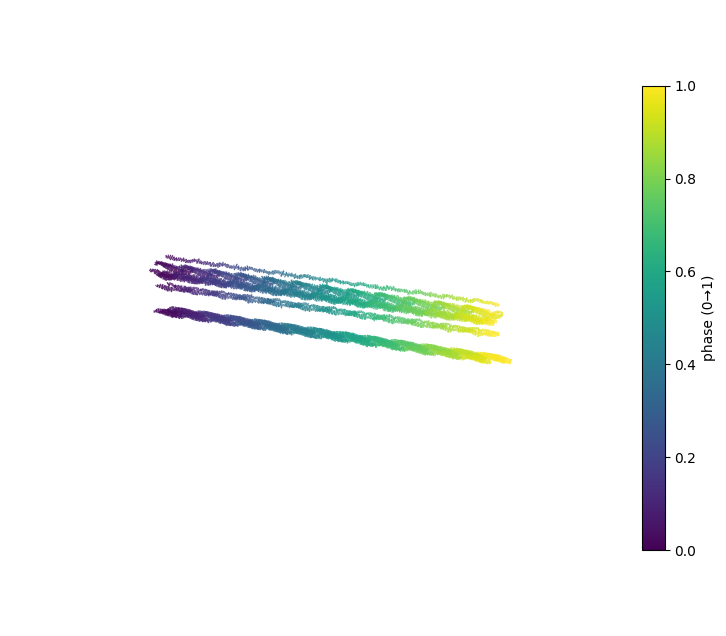

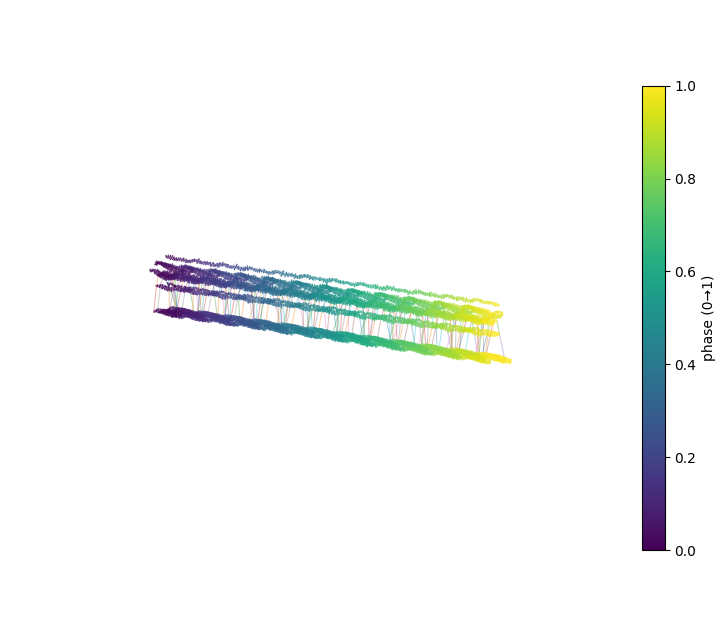

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d.art3d import Line3DCollection


def _as_segments_xyz(xyz: np.ndarray) -> np.ndarray:
    xyz = np.asarray(xyz, dtype=float)
    if xyz.ndim != 2 or xyz.shape[1] != 3 or xyz.shape[0] < 2:
        raise ValueError("Each joint must be an array of shape (T, 3) with T >= 2.")
    return np.stack([xyz[:-1], xyz[1:]], axis=1)


def _speed(xyz: np.ndarray, dt: float) -> np.ndarray:
    v = np.diff(np.asarray(xyz, dtype=float), axis=0) / float(dt)
    return np.linalg.norm(v, axis=1)


def _resolve_joint_names(joints_xyz: dict, name: str) -> list[str]:
    """
    Makes your example bones=[('hip','knee'),('knee','ankle')] work even when the
    actual dict contains hip_L/hip_R, knee_L/knee_R, etc.
    """
    if name in joints_xyz:
        return [name]
    candidates = []
    for suf in ("_L", "_R"):
        k = f"{name}{suf}"
        if k in joints_xyz:
            candidates.append(k)
    return candidates


def motion_as_calligraphy(
    joints_xyz: dict,
    *,
    dt: float = 1.0,
    angle_series: dict | None = None,
    color_mode: str = "phase",          # "phase" or "angle"
    cmap_name: str = "viridis",
    linewidth_range: tuple[float, float] = (0.25, 5.0),
    alpha: float = 0.85,
    add_skeleton: bool = False,
    bones: list[tuple[str, str]] | None = None,
    skeleton_stride: int = 6,
    elev: float = 18,
    azim: float = -65,
    axis_equal: bool = True,
):
    if not isinstance(joints_xyz, dict) or len(joints_xyz) == 0:
        raise ValueError("joints_xyz must be a non-empty dict: {joint_name: (T,3) array}.")

    Ts = {np.asarray(v).shape[0] for v in joints_xyz.values()}
    if len(Ts) != 1:
        raise ValueError("All joints must have the same number of frames T.")
    T = Ts.pop()
    if T < 2:
        raise ValueError("Need T >= 2 frames.")

    cmap = cm.get_cmap(cmap_name)

    if color_mode == "phase":
        cvals = np.linspace(0.0, 1.0, T - 1)
        norm = colors.Normalize(vmin=0.0, vmax=1.0)
    elif color_mode == "angle":
        if angle_series is None or len(angle_series) == 0:
            raise ValueError("color_mode='angle' requires angle_series={name: (T,) array}.")
        all_angles = np.concatenate([np.asarray(a, dtype=float).ravel() for a in angle_series.values()])
        if all_angles.size < 2:
            raise ValueError("angle_series must contain arrays with length >= 2.")
        norm = colors.Normalize(vmin=np.nanmin(all_angles), vmax=np.nanmax(all_angles))
    else:
        raise ValueError("color_mode must be 'phase' or 'angle'.")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    all_pts = []
    for name, xyz in joints_xyz.items():
        xyz = np.asarray(xyz, dtype=float)
        segs = _as_segments_xyz(xyz)
        spd = _speed(xyz, dt=dt)

        smin, smax = np.nanmin(spd), np.nanmax(spd)
        if np.isfinite(smin) and np.isfinite(smax) and smax > smin:
            sscaled = (spd - smin) / (smax - smin)
        else:
            sscaled = np.zeros_like(spd)

        lw0, lw1 = map(float, linewidth_range)
        lws = lw0 + sscaled * (lw1 - lw0)

        if color_mode == "phase":
            seg_colors = cmap(norm(cvals))
        else:
            if name not in angle_series:
                raise ValueError(f"Missing angle_series for joint '{name}' (required for color_mode='angle').")
            ang = np.asarray(angle_series[name], dtype=float)
            if ang.shape[0] != T:
                raise ValueError(f"angle_series['{name}'] must have length T={T}.")
            seg_colors = cmap(norm(ang[:-1]))

        lc = Line3DCollection(segs, linewidths=lws, alpha=float(alpha))
        lc.set_color(seg_colors)
        ax.add_collection3d(lc)

        all_pts.append(xyz)

    # Optional skeleton overlay:
    # Now supports bones specified as ('hip','knee') even if your dict has hip_L/hip_R.
    if add_skeleton:
        if not bones:
            raise ValueError("add_skeleton=True requires bones=[('jointA','jointB'), ...].")
        frames = np.arange(0, T, int(skeleton_stride))
        for ti in frames:
            for a, b in bones:
                a_names = _resolve_joint_names(joints_xyz, a)
                b_names = _resolve_joint_names(joints_xyz, b)

                if not a_names or not b_names:
                    raise ValueError(f"Bone references unknown joint(s): {a}, {b}.")

                # Prefer pairing L with L and R with R when available
                pairs = []
                if (f"{a}_L" in a_names) and (f"{b}_L" in b_names):
                    pairs.append((f"{a}_L", f"{b}_L"))
                if (f"{a}_R" in a_names) and (f"{b}_R" in b_names):
                    pairs.append((f"{a}_R", f"{b}_R"))
                if not pairs:
                    # fall back to Cartesian product
                    pairs = [(aa, bb) for aa in a_names for bb in b_names]

                for aa, bb in pairs:
                    pa = np.asarray(joints_xyz[aa], float)[ti]
                    pb = np.asarray(joints_xyz[bb], float)[ti]
                    ax.plot(
                        [pa[0], pb[0]],
                        [pa[1], pb[1]],
                        [pa[2], pb[2]],
                        linewidth=0.8,
                        alpha=0.35,
                    )

    all_pts = np.concatenate(all_pts, axis=0)
    xmin, ymin, zmin = np.nanmin(all_pts, axis=0)
    xmax, ymax, zmax = np.nanmax(all_pts, axis=0)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)

    if axis_equal:
        cx, cy, cz = (xmin + xmax) / 2, (ymin + ymax) / 2, (zmin + zmax) / 2
        r = 0.5 * max(xmax - xmin, ymax - ymin, zmax - zmin)
        ax.set_xlim(cx - r, cx + r)
        ax.set_ylim(cy - r, cy + r)
        ax.set_zlim(cz - r, cz + r)

    ax.view_init(elev=elev, azim=azim)
    ax.set_axis_off()

    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("phase (0→1)" if color_mode == "phase" else "angle")

    return fig, ax

joints_xyz, angle_series = generate_fake_gait_bilateral(T=480, dt=1/60, seed=0)
# Option A: color by time phase (no angles needed)
fig, ax = motion_as_calligraphy(joints_xyz, dt=1/60, color_mode="phase")
plt.show()

# Option B: color by joint angle (requires angle_series per joint you plot)
# fig, ax = motion_as_calligraphy(joints_xyz, dt=1/60, color_mode="angle", angle_series=angle_series)
# plt.show()

# Optional skeleton overlay (this now works with bilateral data: hip_L/hip_R etc.)
bones = [
    ("hip", "knee"),
    ("knee", "ankle"),
]
fig, ax = motion_as_calligraphy(
    joints_xyz,
    dt=1/60,
    color_mode="phase",
    add_skeleton=True,
    bones=bones,
)
plt.show()


C:\Users\jacob\AppData\Local\Temp\ipykernel_43708\3215413754.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


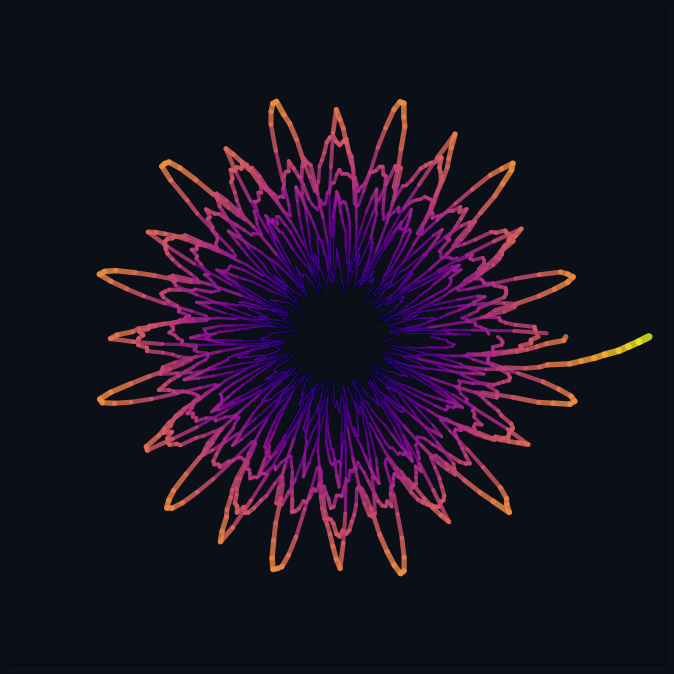

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.collections import LineCollection
import matplotlib.patheffects as pe


def _as_segments_xy(xy):
    return np.stack([xy[:-1], xy[1:]], axis=1)


def motion_as_flower(
    joints_xyz,
    *,
    center_xyz,
    dt=1.0,
    cmap_name="plasma",
    linewidth_range=(0.6, 5.2),
    alpha=0.78,
    theta_direction=-1,
):
    T = next(iter(joints_xyz.values())).shape[0]

    theta = theta_direction * np.linspace(0, 2 * np.pi, T, endpoint=False)
    cmap = cm.get_cmap(cmap_name)

    radii = {}
    all_r = []

    for name, xyz in joints_xyz.items():
        rel = xyz - center_xyz
        r = np.linalg.norm(rel[:, :2], axis=1)
        radii[name] = r
        all_r.append(r[:-1])

    all_r = np.concatenate(all_r)
    rmin, rmax = all_r.min(), all_r.max()
    cnorm = colors.Normalize(rmin, rmax)

    fig, ax = plt.subplots(figsize=(8.5, 8.5))

    for name, r in radii.items():
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        xy = np.column_stack([x, y])
        segs = _as_segments_xy(xy)

        rseg = r[:-1]
        colors_seg = cmap(cnorm(rseg))

        lw0, lw1 = linewidth_range
        rs = (rseg - rmin) / (rmax - rmin + 1e-12)
        lws = lw0 + rs * (lw1 - lw0)

        lc = LineCollection(segs, linewidths=lws, colors=colors_seg, alpha=alpha)
        lc.set_capstyle("round")
        lc.set_joinstyle("round")
        ax.add_collection(lc)

    # 🔑 THIS IS WHAT WAS MISSING
    lim = rmax * 1.05
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

    # # colorbar
    # sm = cm.ScalarMappable(norm=cnorm, cmap=cmap)
    # sm.set_array([])
    # fig.colorbar(sm, ax=ax, fraction=0.045, pad=0.02, label="radius")

    return fig, ax


# ---------- CALL ----------
fig, ax = motion_as_flower(
    joints_xyz={
        "wrist_L": joints_xyz["wrist_L"],
        "wrist_R": joints_xyz["wrist_R"],
        "ankle_L": joints_xyz["ankle_L"],
        "ankle_R": joints_xyz["ankle_R"],
        "toe_L": joints_xyz["toe_L"],
        "toe_R": joints_xyz["toe_R"],
    },
    center_xyz=joints_xyz["pelvis"],
    dt=1/60,
)

# styling (your part)
bg = "#0b0f17"
fig.set_facecolor(bg)
ax.set_facecolor(bg)

for artist in ax.get_children():
    if hasattr(artist, "set_path_effects"):
        artist.set_path_effects([
            pe.Stroke(linewidth=2.0, foreground=(0, 0, 0, 0.30)),
            pe.Normal(),
        ])

plt.show()


C:\Users\jacob\AppData\Local\Temp\ipykernel_43708\3215413754.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


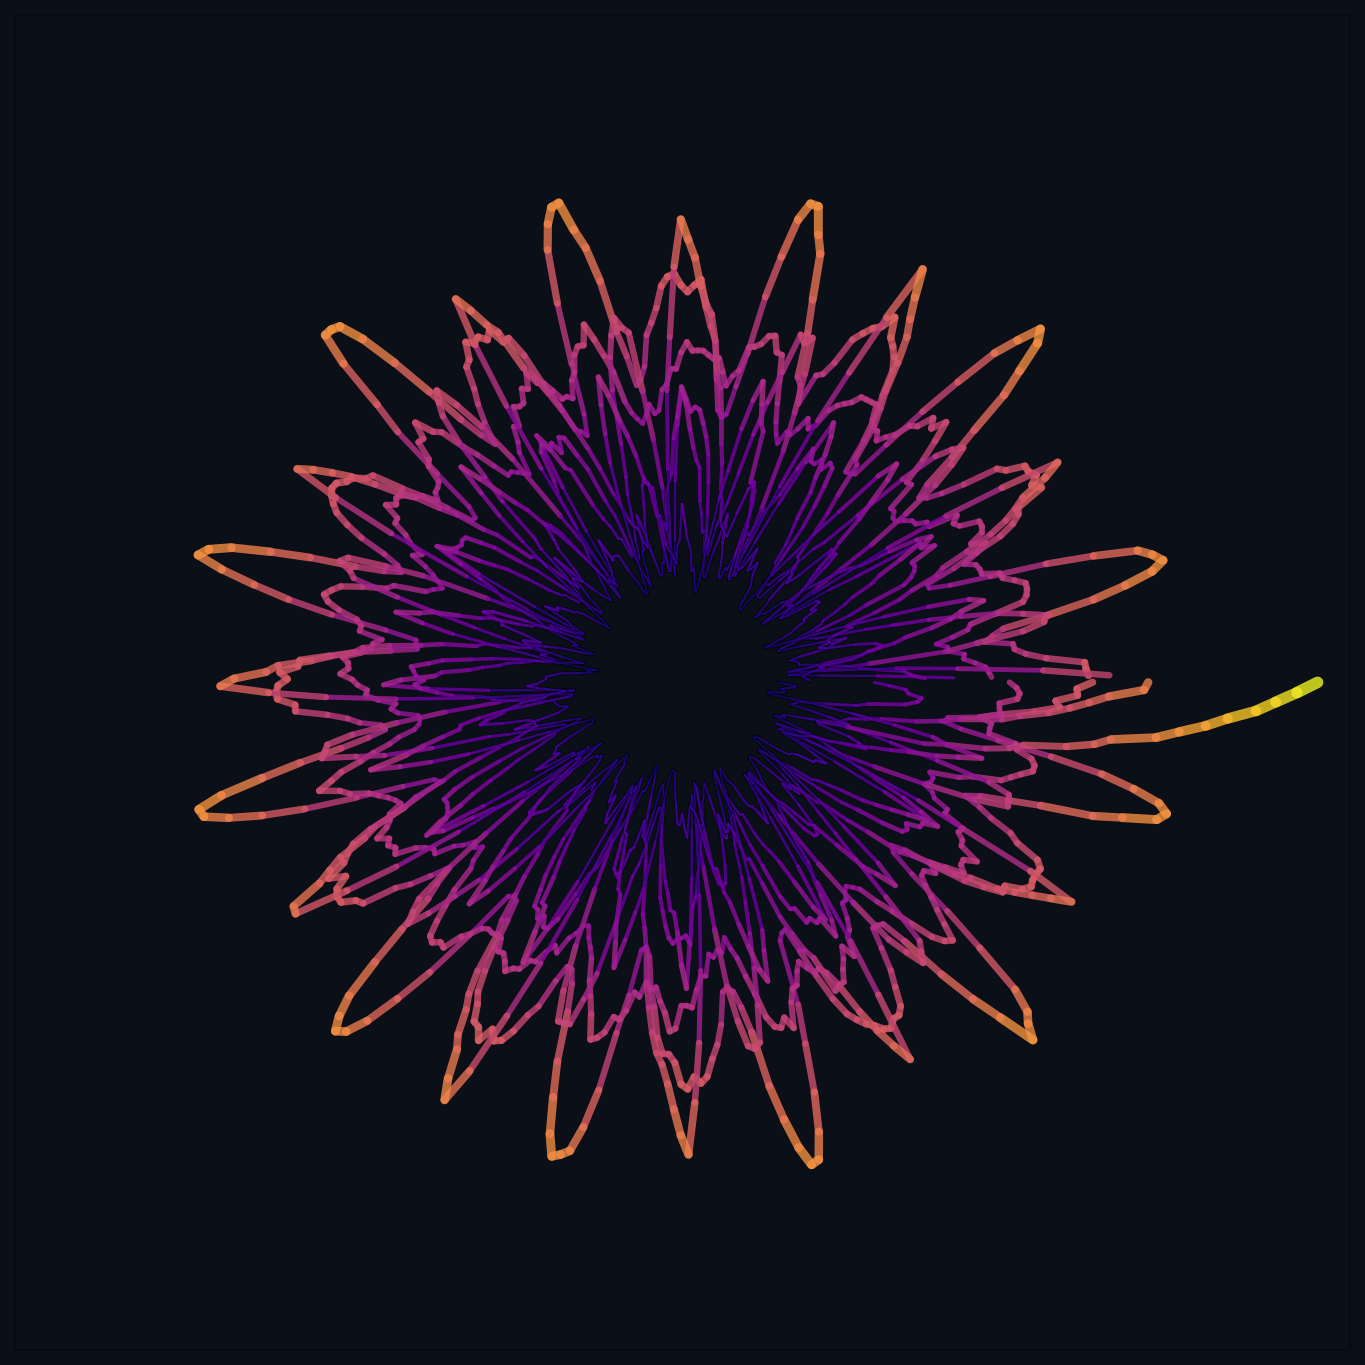

In [26]:

# ---------- CALL IT (uses your existing joints_xyz) ----------
fig, ax = motion_as_flower(
    joints_xyz={
        "wrist_L": joints_xyz["wrist_L"],
        "wrist_R": joints_xyz["wrist_R"],
        "ankle_L": joints_xyz["ankle_L"],
        "ankle_R": joints_xyz["ankle_R"],
        "toe_L": joints_xyz["toe_L"],
        "toe_R": joints_xyz["toe_R"],
    },
    center_xyz=joints_xyz["pelvis"],
    dt=1/60,
    cmap_name="plasma",
    linewidth_range=(0.6, 5.2),
    alpha=0.78,
    theta_direction=-1,
)

# ---------- YOUR STYLING ----------
xlim0, ylim0 = ax.get_xlim(), ax.get_ylim()

bg = "#0b0f17"
fig.set_size_inches(8.5, 8.5)
fig.set_dpi(160)
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)
ax.set_aspect("equal", adjustable="box")

ax.set_xticks([]); ax.set_yticks([])
for s in ax.spines.values():
    s.set_visible(False)

for artist in ax.get_children():
    if hasattr(artist, "set_antialiased"):
        artist.set_antialiased(True)
    if hasattr(artist, "set_capstyle"):
        artist.set_capstyle("round")
    if hasattr(artist, "set_joinstyle"):
        artist.set_joinstyle("round")
    if hasattr(artist, "set_path_effects"):
        artist.set_path_effects([
            pe.Stroke(linewidth=2.0, foreground=(0, 0, 0, 0.30)),
            pe.Normal(),
        ])
    if hasattr(artist, "set_clip_on"):
        artist.set_clip_on(False)

ax.set_xlim(xlim0)
ax.set_ylim(ylim0)

fig.tight_layout(pad=0.6)
plt.show()

In [27]:
import matplotlib.patheffects as pe

fig, ax = motion_as_flower(
    joints_xyz={
        "wrist_L": joints_xyz["wrist_L"],
        "wrist_R": joints_xyz["wrist_R"],
        "ankle_L": joints_xyz["ankle_L"],
        "ankle_R": joints_xyz["ankle_R"],
        "toe_L": joints_xyz["toe_L"],
        "toe_R": joints_xyz["toe_R"],
    },
    center_xyz=joints_xyz["pelvis"],
    dt=1/60,
    theta_mode="phase",
    radius_mode="xy",
    color_mode="phase",
    cmap_name="plasma",
    linewidth_range=(0.6, 5.2),
    alpha=0.78,
    theta_direction=-1,
)

# preserve original view (prevents “round -> squished/clipped”)
xlim0, ylim0 = ax.get_xlim(), ax.get_ylim()

bg = "#0b0f17"
fig.set_size_inches(8.5, 8.5)
fig.set_dpi(160)
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

# use box (not datalim)
ax.set_aspect("equal", adjustable="box")

ax.set_xticks([]); ax.set_yticks([])
for s in ax.spines.values():
    s.set_visible(False)

# subtle outline (don’t over-thicken)
for artist in ax.get_children():
    if hasattr(artist, "set_antialiased"):
        artist.set_antialiased(True)
    if hasattr(artist, "set_capstyle"):
        artist.set_capstyle("round")
    if hasattr(artist, "set_joinstyle"):
        artist.set_joinstyle("round")
    if hasattr(artist, "set_path_effects"):
        artist.set_path_effects([
            pe.Stroke(linewidth=2.0, foreground=(0, 0, 0, 0.30)),
            pe.Normal(),
        ])
    if hasattr(artist, "set_clip_on"):
        artist.set_clip_on(False)

ax.set_xlim(xlim0)
ax.set_ylim(ylim0)

fig.tight_layout(pad=0.6)
plt.show()


TypeError: motion_as_flower() got an unexpected keyword argument 'theta_mode'

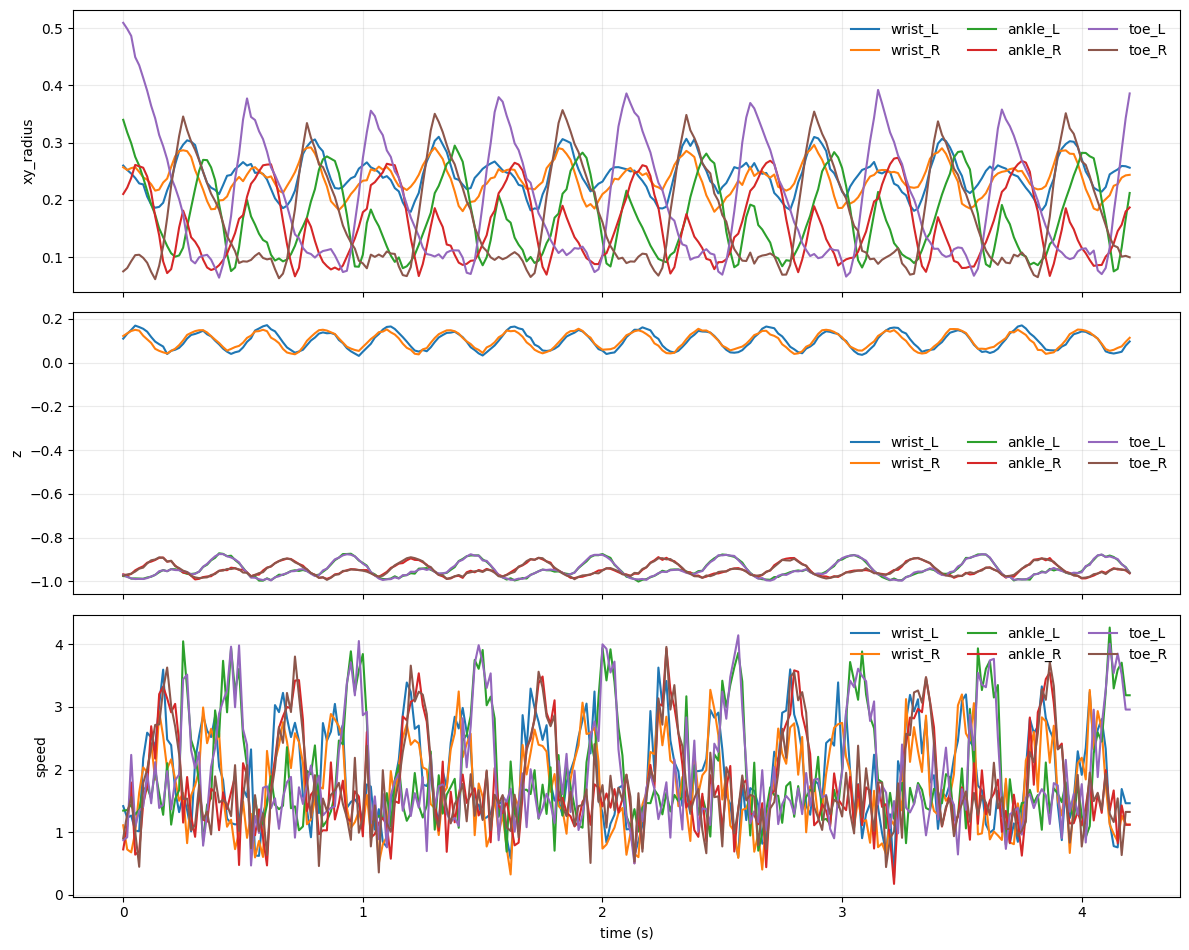

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_joint_timeseries(
    joints_xyz: dict,
    *,
    center_xyz: np.ndarray | None = None,
    dt: float = 1.0,
    joints: list[str] | None = None,
    features: tuple[str, ...] = ("xy_radius", "z", "speed"),
):
    Ts = {np.asarray(v).shape[0] for v in joints_xyz.values()}
    if len(Ts) != 1:
        raise ValueError("All joints must have the same T.")
    T = Ts.pop()
    if T < 2:
        raise ValueError("Need T >= 2.")

    if center_xyz is None:
        center_xyz = np.zeros((T, 3), dtype=float)
    center_xyz = np.asarray(center_xyz, dtype=float)
    if center_xyz.shape != (T, 3):
        raise ValueError("center_xyz must be shape (T,3) and match T of joints.")

    if joints is None:
        joints = list(joints_xyz.keys())

    t = np.arange(T) * float(dt)

    nrows = len(features)
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(12, 3.2 * nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    for name in joints:
        xyz = np.asarray(joints_xyz[name], dtype=float)
        rel = xyz - center_xyz

        series = {}
        series["xy_radius"] = np.linalg.norm(rel[:, :2], axis=1)
        series["z"] = rel[:, 2]
        sp = np.linalg.norm(np.diff(rel, axis=0) / float(dt), axis=1)
        series["speed"] = np.r_[sp, sp[-1]]

        for i, f in enumerate(features):
            if f not in series:
                raise ValueError(f"Unknown feature: {f}")
            axes[i].plot(t, series[f], label=name)

    for ax, f in zip(axes, features):
        ax.set_ylabel(f)
        ax.grid(True, alpha=0.25)
        ax.legend(ncol=3, frameon=False)

    axes[-1].set_xlabel("time (s)")
    fig.tight_layout()
    return fig, axes


fig_ts, axes_ts = plot_joint_timeseries(
    joints_xyz={
        "wrist_L": joints_xyz["wrist_L"],
        "wrist_R": joints_xyz["wrist_R"],
        "ankle_L": joints_xyz["ankle_L"],
        "ankle_R": joints_xyz["ankle_R"],
        "toe_L": joints_xyz["toe_L"],
        "toe_R": joints_xyz["toe_R"],
    },
    center_xyz=joints_xyz["pelvis"],
    dt=1/60,
)
plt.show()
